In [1]:
import cloudViewer as cv3d
import numpy as np
import os
import sys

# monkey patches visualization and provides helpers to load geometries
sys.path.append('../..')
import cloudViewer_tutorial as cv3dtut
# change to True if you want to interact with the visualization windows
cv3dtut.interactive = not "CI" in os.environ

# Mesh deformation
If we want to deform a triangle mesh according to a small number of constraints, we can use mesh deformation algorithms. Open3D implements the as-rigid-as-possible method by [\[SorkineAndAlexa2007\]](../reference.html#SorkineAndAlexa2007) that optimizes the following energy function

\begin{equation}
\sum_i \sum_{j \in \mathcal{N}(i)} w_{ij} || (\mathbf{p}'_i - \mathbf{p}'_j) - \mathbf{R}_i (\mathbf{p}_i - \mathbf{p}_j)||^2 \,,
\end{equation}

where $\mathbf{R}_i$ are the rotation matrices that we want to optimize for, and $\mathbf{p}_i$ and $\mathbf{p}'_i$ are the vertex positions before and after the optimization, respectively. $\mathcal{N}(i)$ is the set of neighbors of vertex $i$. The weights $w_{ij}$ are cotangent weights.

Open3D implements this method in `deform_as_rigid_as_possible`. The first argument to this method is a set of `constraint_ids` that refer to the vertices in the triangle mesh. The second argument `constrint_pos` defines at which position those vertices should be after the optimization. The optimization process is an iterative scheme. Hence, we also can define the number of iterations via `max_iter`.

In [2]:
mesh = cv3dtut.get_armadillo_mesh()

vertices = np.asarray(mesh.get_vertices())
static_ids = [idx for idx in np.where(vertices[:, 1] < -30)[0]]
static_pos = []
for id in static_ids:
    static_pos.append(vertices[id])
handle_ids = [2490]
handle_pos = [vertices[2490] + np.array((-40, -40, -40))]
constraint_ids = cv3d.utility.IntVector(static_ids + handle_ids)
constraint_pos = cv3d.utility.Vector3dVector(static_pos + handle_pos)

with cv3d.utility.VerbosityContextManager(
        cv3d.utility.VerbosityLevel.Debug) as cm:
    mesh_prime = mesh.deform_as_rigid_as_possible(constraint_ids,
                                                  constraint_pos,
                                                  max_iter=50)

Original Mesh


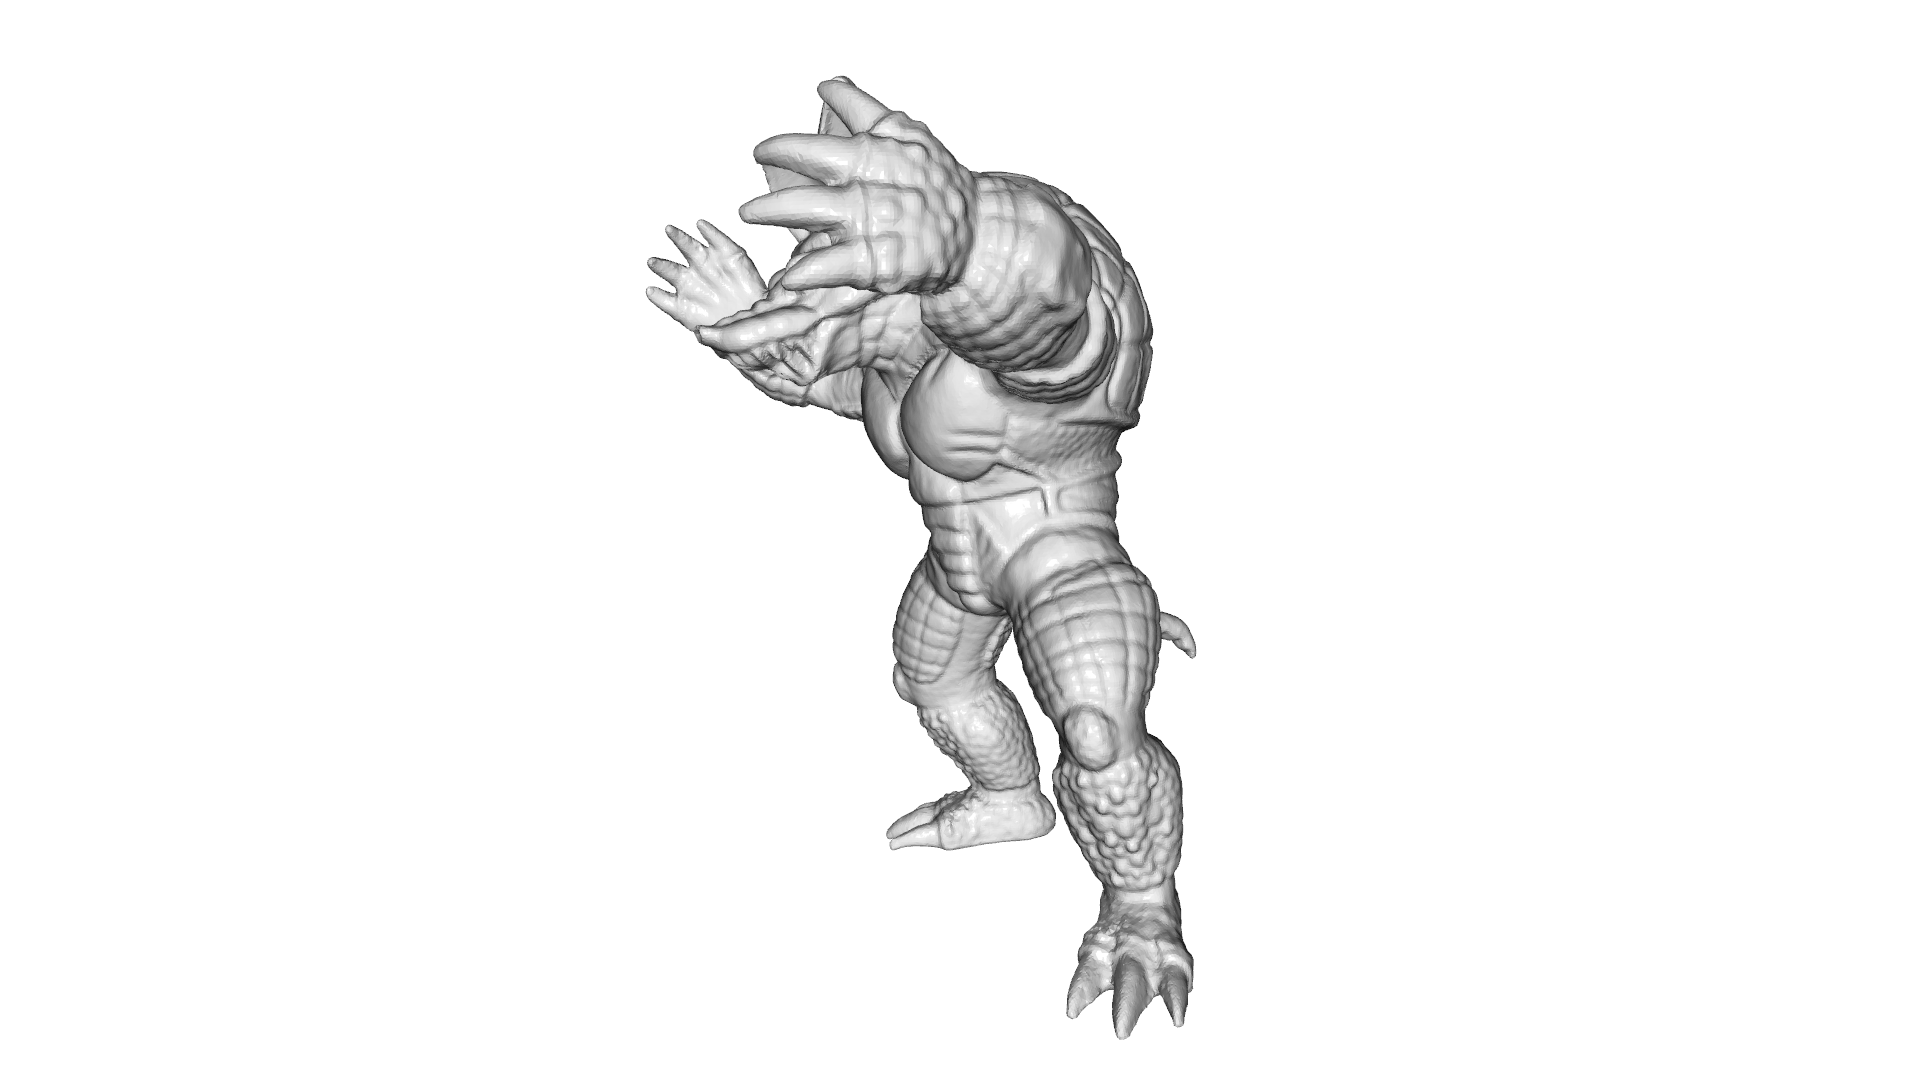

Deformed Mesh


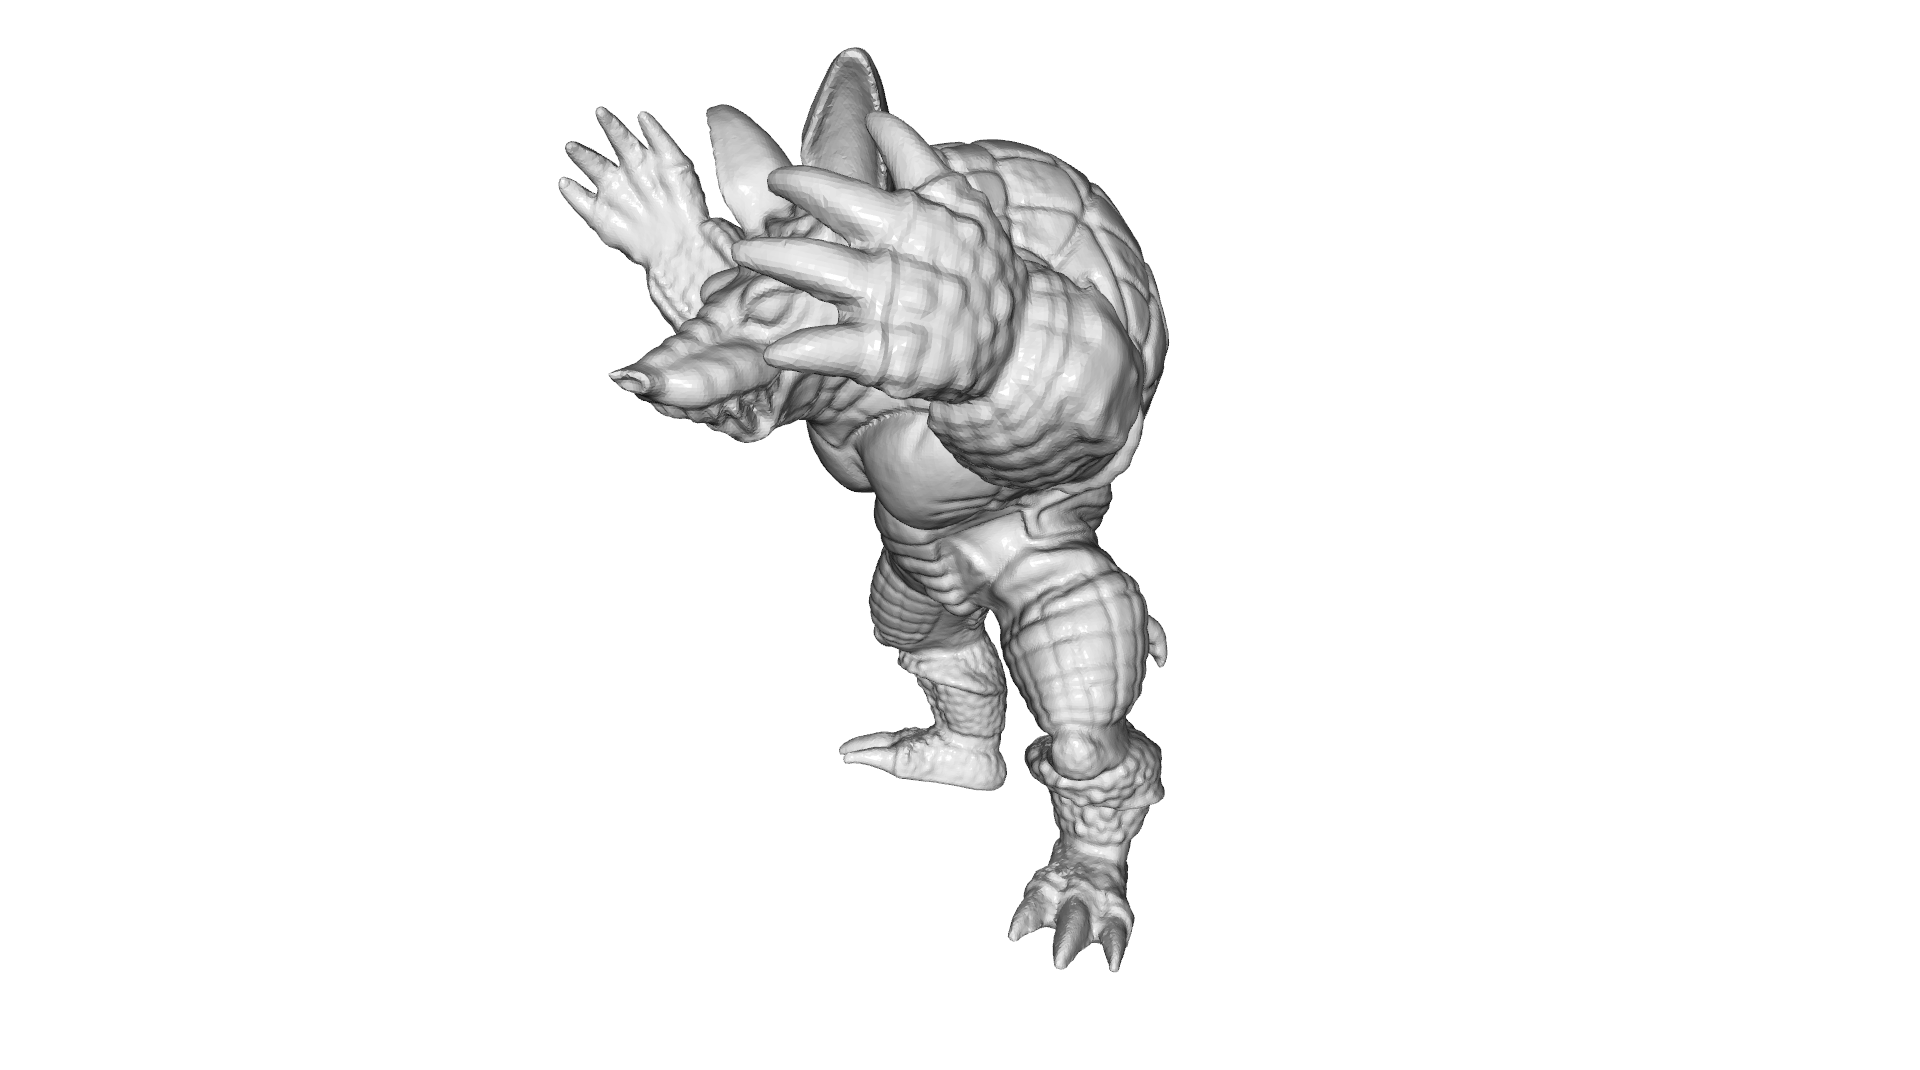

In [3]:
print('Original Mesh')
R = mesh.get_rotation_matrix_from_xyz((0, np.pi, 0))
cv3d.visualization.draw_geometries([mesh.rotate(R, center=mesh.get_center())])
print('Deformed Mesh')
mesh_prime.compute_vertex_normals()
cv3d.visualization.draw_geometries(
    [mesh_prime.rotate(R, center=mesh_prime.get_center())])

## Smoothed ARAP
Open3D also implements a smoothed version of the ARAP objective defined as 

\begin{equation}
\sum_i \sum_{j \in \mathcal{N}(i)} w_{ij} || (\mathbf{p}'_i - \mathbf{p}'_j) - \mathbf{R}_i (\mathbf{p}_i - \mathbf{p}_j)||^2 + \alpha A ||\mathbf{R}_i - \mathbf{R}_j||^2\,,
\end{equation}

that penalizes a deviation of neighboring rotation matrices. $\alpha$ is a trade-off parameter for the regularization term and $A$ is the surface area. 

The smoothed objective can be used in `deform_as_rigid_as_possible` by using the argument `energy` with the parameter `Smoothed`.